Lab 7 : Rețele Neurale în PyTorch
===========================

Exemple introduse în acest laborator:
- preprocesarea datelor în PyTorch ([data transforms](https://pytorch.org/docs/stable/torchvision/transforms.html))
- utilizarea unui [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
- definirea unui MLP si a unei arhitecturi convoluționale în PyTorch
- efectul utilizării normalizării la nivel de batch (batch normalization - [Descriere](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c), [Modul PyTorch](https://pytorch.org/docs/stable/nn.html#batchnorm2d)) în arhitecturi convoluționale adânci
- ciclul de antrenare al unei rețele în PyTorch



In [70]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import torch
import torch.nn as nn

# Definirea mediului pe care va rula codul de antrenare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import collections
import enum
import warnings
warnings.filterwarnings('ignore')

Running code @ cuda


## Descărcare și preparare date

* **Cifar-10** este echivalentul MNIST pentru imagini naturale RGB

* cuprinde 60k 32x32 imagini color din 10 clase: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

* train: 50k; test: 10k


**Exemplu 1: Implementarea unor metode de augmentare de date**

În Pytorch pot fi folosite _transformări de date_ la momentul încărcării în memorie a unui set de date. 
Pentru aceasta se pot utiliza clase predefinite (din pachetul `torchvision.transforms`) sau pot fi construite clase custom.

În acest exemplu folosim _transforms_ pentru a aplica două tehnici de augmentare a datelor, folosite la antrenare: oglindiri aleatoare a imaginilor și crop-uri aleatoare ale imaginii (sunt folosite clase existente în pachetul `torchvision.transforms`.


In [71]:
# Prepare data 
import torchvision
import torchvision.transforms as transforms

NUM_WORKERS = 2


TRAIN_DATASET_SIZE = 50000
TEST_DATASET_SIZE = 10000

CIFAR10_IMG_WIDTH = 32
CIFAR10_IMG_HEIGHT = 32

DATA_MEAN = (0.5, 0.5, 0.5)		# define the mean for the scaling transform - PIL images already come given in 
DATA_STD = (0.5, 0.5, 0.5)		# define the standard deviation for the scaling transform
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),     # apply random horizontal flip
        transforms.RandomCrop(                          # apply random crop, after padding image with 4 values on each side, using `reflect` mode
            size=(CIFAR10_IMG_WIDTH, CIFAR10_IMG_HEIGHT), 
            padding=(4, 4), 
            padding_mode="reflect"),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEAN, DATA_STD)       # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
    ] 
)


test_transform = transforms.Compose(
    [
        transforms.ToTensor(),                          # on test set we only need to apply the same normalization
        transforms.Normalize(DATA_MEAN, DATA_STD) 
    ] 
)



train_images = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                            transform=train_transform)

test_images = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, 
                                           transform=test_transform)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')


Files already downloaded and verified
Files already downloaded and verified
Size of training images (50000, 32, 32, 3)
Size of training labels 50000
Size of test images (10000, 32, 32, 3)
Size of test labels 10000


## Afișare imagini
Implementarea unei „galerii” de imagini pentru vizualizarea setului de date.

In [72]:
MAX_IMAGES = 10

def gallery(images, label, title='Input images'):
    class_dict = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_frames, h, w, num_channels = images.shape
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames, figsize=(num_frames, 1), subplot_kw={'xticks': [], 
                                                                                'yticks': []})
    for i in range(0, num_frames):
        if num_channels == 3:
            axes[i].imshow(np.squeeze(images[i]))
        else:
            axes[i].imshow(np.squeeze(images[i]), cmap='gray')
        axes[i].set_title(class_dict[label[i]])
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(axes[i].get_yticklabels(), visible=False)
    ff.subplots_adjust(wspace=0.1)
    plt.show()


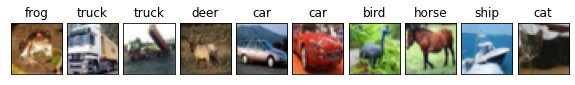

In [73]:
gallery(train_images.data, train_images.targets)


## Pregătirea datelor pentru antrenare și testare
* pentru antrenare folosim optimizatori stocastici (e.g. SGD, Adam), asa că trebuie sa putem eșantiona exemple aleatoare din setul de date pentru a forma mini-batch-uri
* pentru testare iterăm în mod secvențial prin setul de date

In [74]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 100  #@param
BATCH_SIZE_TEST = 100  #@param
NO_WORKERS = 8  #@param
SHUFFLE_DATA = True

# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')


Shape of training images: torch.Size([100, 3, 32, 32])
Shape of training labels: torch.Size([100])


In [75]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')


Shape of test images: torch.Size([100, 3, 32, 32])
Shape of test labels: torch.Size([100])


### Setări generale: nume model, utilizare batch normalization, utilizare regularizare

In [92]:
model = "mlp" # @param['mlp', 'lenet', 'deep_net'] 
flag_batch_norm = 'OFF'  # @param['ON', 'OFF']
flag_regularize = True     # @param['True', 'False'] {type:"raw"}


## 1. Definirea unui MLP

Vom defini un model de tip MLP cu activari ReLU:
  * Linearize
  * FC(3 * 32 * 32, 256) + ReLU
  * FC(256, 256) + ReLU
  * FC(256, 10)

In [93]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        in_size = 3 * 32 * 32
        
        self.fc1 = nn.Linear(in_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        #x = torch.flatten(x, 1)
        x = x.view(-1, 3 * 32 * 32)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 2. Definirea retelei convolutionale LeNet
  * [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)(3, 6, k=5) + ReLU  # img size = 28x28
  * [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)(2,2) # img size = 14x14
  * Conv2d(6, 16, 5) + ReLU # img size = 10x10
  * MaxPool2D(2,2) # img size = 5x5
  * Linearize(16, 5, 5)
  * FC(16 * 5 * 5, 120) + ReLU
  * FC(120, 84) + ReLU
  * FC(84, 10)


In [78]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # TODO 2.1 - Definiti straturile din arhitectura LeNet

    def forward(self, x):
        # TODO 2.2 - Scrieti pasul de forward pentru arhitectura LeNet
        return x

## 3. Definirea arhitecturii unei retele adanci - DeepConvNet

Implementarea propusă se inspira din modelele de tip [ResNet](https://d2l.ai/chapter_convolutional-modern/resnet.html).
Astfel, reteaua este construita dupa urmatorul sablon:
  * Conv2d(3, 16, k=7, stride=2, padding=3, bias=False) + Norm + ReLU
  * Conv2d(16, 64, k=1, stride=1) + Norm + ReLU
  * 3 x ConvBlock(16, 64, Norm)
  * Conv2d(64, 128, k=1, stride=2) + Norm + ReLU
  * 3 x ConvBlock(32, 128, Norm)
  * Conv2d(128, 256, k=1, stride=2) + Norm +ReLU
  * 3 x ConvBlock(64, 256, Norm)
  * [AdaptiveAveragePooling](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)((1,1)) + Flatten
  * FC(256,10)

### 3.1 Definirea unui strat de normalizare de tip identitate
Inputul este forwardat ca atare.

In [79]:
class EmptyNorm(nn.Module):
    def __init__(self, *args, **kwargs):
        super(EmptyNorm, self).__init__()
        self._modules = dict()
    
    def forward(self, input):
        return input

### 3.2 Apeluri auxiliare de convoluții 3x3 și 1x1 folosite într-un bloc ConvBlock 
Instantiațe în mod corespunzător folosind clasa de tip [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html) din PyTorch 

In [80]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    """
    3x3 2D convolution with padding=1
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    @:param padding: the padding to apply, default is 1 to keep width and height the same in the output activation maps 
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 2D convolution
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


### 3.3: Definirea unui ConvBlock similar cu un block ResNet cu "gâtuire" (bottleneck)

Blocul de tip "bottleneck" este definit ca în figura următoare.

![ResNet-50 Bottleneck block](https://github.com/asorici/NN-labs/blob/master/Lab3-CNN/img/Bottleneck-Blocks.png?raw=1)


In [81]:
class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer=EmptyNorm):
        super(ConvBlock, self).__init__()

        # first conv 1x1 layer which implements the bottlenecking
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)

        # conv 3x3 layer which applies the stride given as parameter
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)

        # conv 1x1 layer where the number of output channels is "expanded" according to the defined expansion factor
        # according to the above figure, the expansion factor is set to 4
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # first layer conv1 + bn1 + relu
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        # second layer conv2 + bn2 + relu
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        # third layer conv3 + bn3
        out = self.conv3(out)
        out = self.norm3(out)

        # add identity to residual and apply relu
        out += identity
        out = self.relu(out)

        return out



### 3.4. Definirea arhitecturii DeepConvNet - compunerea blocurilor funcționale


In [82]:
class DeepConvNet(nn.Module):
    def __init__(self, norm_layer=EmptyNorm, base_depth=16, expansion=4, nr_layer_blocks=3, num_classes=10):
        super(DeepConvNet, self).__init__()

        self.norm_layer = norm_layer
        self.base_depth = base_depth
        self.conv1 = nn.Conv2d(3, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)  # image is now 16x16
        self.norm1 = norm_layer(self.base_depth)
        self.relu = nn.ReLU(inplace=True)

        # change to 64 channels base and image size 16x16
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = norm_layer(depth1)

        # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 128 channels base and image size 8x8
        depth2 = depth1 * 2
        # TODO 3.1 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        # self.conv_depth2 = ...
        # self.norm_depth2 = ...

        # #### Layer 2, 3 blocks
        # TODO 3.2 - Definiti secventa de ConvBlocks pentru Layer 2
        # self.layer2 = ...

        # change to 256 chanels and image size 4x4
        depth3 = depth2 * 2
        # TODO 3.3 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        # self.conv_depth3 = ...
        # self.norm_depth3 = ...

        # Layer 3, 3 blocks
        # TODO 3.4 - Definiti secventa de ConvBlocks pentru Layer 3
        # self.layer3 = ...

        # AveragePooling
        # TODO 3.5 - Definiti straturile de GlobalAveragePooling si stratul Fully Connected
        # self.avgpool = ...
        # self.fc = ...


    def forward(self, x):
        # initial conv
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        # TODO 3.6 apply depth1 transform + layer 1
        # x = ...

        # TODO 3.7 apply depth2 transform + layer 2
        # x = ...

        # TODO 3.8 apply depth3 transform + layer 3
        # x = ...
        
        # apply global average pooling + linearize + FC
        # x = ...

        return x

## 4. Pregătirea pipeline-ului de antrenare

### Parametrizarea preprocesării datelor

In [83]:
# First define the preprocessing ops for the train/test data
crop_height = 32  # @param 
crop_width = 32  # @param
NUM_CLASSES = 10  # @param


### 4.1 Initializarea modelului rețelei și funcții auxiliare pentru inspectarea modelului definit

In [ ]:
net = None                       # type: nn.Module

if model == "mlp":
  net = MLP(num_classes=NUM_CLASSES)
elif model == "lenet":
  net = LeNet()
else:
  if flag_batch_norm == "ON":
      net = DeepConvNet(norm_layer=nn.BatchNorm2d, base_depth=16, expansion=4, 
                        nr_layer_blocks=3, num_classes=NUM_CLASSES)
  else:
      net = DeepConvNet(norm_layer=EmptyNorm, base_depth=16, expansion=4, 
                        nr_layer_blocks=3, num_classes=NUM_CLASSES)
    
net.train()               # Default after init is train
net = net.to(device)      # Move network to device

print(list(net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)


In [85]:
# Get number of parameters in a model by iterating through the model parameters
def get_num_params(model):
    num_params = 0
    for params in model.parameters():
        num_params += params.shape.numel()
        
    return num_params


In [ ]:
# Get number of parameters in the model. Verify that we have implemented models correctly
print("Total number of parameters of models")
print(str(net.__class__), ": ", get_num_params(net))  

In [87]:
def top_k_accuracy(k, target, output):
    batch_size = target.size(0)
    
    _, pred = output.topk(k, 1, True, True)
    
    pred = pred.t()
    correct = pred.eq(target.to(device).view(1, -1).expand_as(pred))

    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    correct_k.mul_(100.0 / batch_size)
    
    return correct_k


### 4.2 Parametrizarea optimizatorului

In [99]:
lr_init = 0.001                # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-4  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
#optimizer = torch.optim.SGD(net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
optimizer = torch.optim.Adam(net.parameters(), lr=lr_init)

if flag_regularize:
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

### Afișarea loss-ului

In [89]:
# Function that takes a list of losses and plots them.
REFRESH_EVERY = 1000

def plot_losses(loss_list, steps, ct):
    if ct % REFRESH_EVERY == 0:
        display.clear_output(wait=True)
    
    display.display(pl.gcf())
    pl.plot(steps, loss_list, c='b')
    time.sleep(1.0)

### Parametrizarea iterațiilor de antrenare, raportare și testare

In [97]:
# Define number of training iterations and reporting intervals
TRAIN_ITERS = 100e3  # @param
REPORT_TRAIN_EVERY = 100  # @param
PLOT_EVERY = 100  # @param
REPORT_TEST_EVERY = 200  # @param
TEST_ITERS = 100  # @param

## 5. Antrenarea modelului

In [ ]:
# Question: What is the accuracy of the model at iteration 0, i.e. before training starts?

EPOCHS = int(TRAIN_ITERS / (TRAIN_DATASET_SIZE / BATCH_SIZE_TRAIN))

train_iter = 0
losses = []
steps = []

# simulate an inifinte test data provider by looping over the test data
test_data_provider = loopy_test_loader(test_loader)

# set model in train mode
net.train()

running_loss = 0.0
running_acc = 0.0
ct = 0

for epoch in range(int(EPOCHS)):  # loop over the dataset multiple times
    
    for i, data in enumerate(train_loader, 0):
        # set the learning rate and decay according to iteration schedule
        lr_scheduler.step()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += top_k_accuracy(1, labels, outputs)
        
        if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
            train_loss = running_loss / REPORT_TRAIN_EVERY
            train_acc = running_acc / REPORT_TRAIN_EVERY
            
            print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
            print('[%d, %5d] loss: %.5f, acc: %.5f' %
                  (epoch + 1, i + 1, train_loss, train_acc))
            
            losses.append(train_loss)
            steps.append(train_iter)
            
            running_loss = 0
            train_loss = 0
            running_acc = 0
            
        if train_iter % PLOT_EVERY == 0:
            plot_losses(losses, steps, train_iter)
            
        train_iter += 1
    
        if train_iter % REPORT_TEST_EVERY == 0:
            # set model in test mode
            net.eval()
            
            with torch.no_grad():
                # evaluate over at most TEST_ITER sub samples from the test_loader
                test_iter = 0
                test_loss = 0
                correct = 0
                
                while test_iter < TEST_ITERS:
                #for j, test_data in enumerate(test_loader, start=test_ct):
                    test_data = next(test_data_provider)
                        
                    # get the test inputs; data is a list of [inputs, labels]
                    test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
                    
                    out = net(test_inputs)
                    test_loss += criterion(out, test_labels)
                    
                    correct += top_k_accuracy(1, test_labels, out)
                    
                    test_iter += 1
                    
                avg_test_loss = test_loss / TEST_ITERS
                avg_acc = correct / TEST_ITERS
                
                print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                    % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                
            # set model back in train mode
            net.train()
    
print('Finished Training')

## 6. Interpretarea rezultatelor
**Răspundeți la următoarele întrebări:**
1. Care este diferenta de acuratete intre MLP, LeNet si DeepConvNet **dupa 8 epoci de antrenare**?
2. Care este efectul utilizării normalizării de tip BatchNorm pentru retelele convolutionale adanci?